KURULUMLAR

In [ ]:
!pip install accelerate==0.25.0 torchmetrics==1.2.1 tqdm==4.66.1 transformers==4.36.2 diffusers==0.25.0 einops==0.7.0 bitsandbytes==0.39.0 scipy==1.11.1 opencv-python gradio==4.24.0 fvcore cloudpickle omegaconf pycocotools basicsr av onnxruntime==1.16.2

In [ ]:
!pip install ultralytics

In [ ]:
!pip install firebase_admin

YOLO ENTEGRESİ

In [ ]:
import time
import cv2
import os


from ultralytics import YOLO
import firebase_admin
from firebase_admin import credentials, firestore, storage



#veri yolu için zamana göre isimlendirme
veri_yol = ("/"+str(time.strftime('%c'))).replace(" ","-")


#veri yolu ve görüntü kaydetme sırası için yardımcı bir class, sadece veri tutacak
class Veri:
    yol = ""
    counter = 0

#Bir klasör yok ise oluşturma işlemi
if (not os.path.exists(os.getcwd() + veri_yol)):
    os.mkdir(os.getcwd() + veri_yol)

#yolo modeli yükle
model = YOLO("yolov8n.pt")


#firebase yapılandır
credentialData = credentials.Certificate("hackathonproject-5e6ef-firebase-adminsdk-mubj0-d18674376c.json")
firebase_admin.initialize_app(credentialData, {
'storageBucket': 'hackathonproject-5e6ef.appspot.com'
})





100%|██████████| 6.25M/6.25M [00:00<00:00, 299MB/s]


FileNotFoundError: [Errno 2] No such file or directory: 'hackathonproject-5e6ef-firebase-adminsdk-mubj0-d18674376c.json'

In [ ]:

#bilgileri buluta yükle
def firebase_veri_yukle(gorsel_Adi,nesne_sayi,tumBilgi):

    firestoreDb = firestore.client()
    bucket = storage.bucket()


    #document sayısını öğrenme
    veri_document_sayi = firestoreDb.collection("urunVeri").get()

    #firebase tarih bilgisi
    timestamp = firestore.SERVER_TIMESTAMP

    #veri girişi
    deger = len(veri_document_sayi)+1
    belge_ref = firestoreDb.collection("urunVeri").document("urunBilgi"+str(deger))


    #veriler
    urun_verileri = {
            'ID':str(deger),
            'gorsel_adi': "urun_Gorseller"+f"{gorsel_Adi}",
            'konum':"Yozgat/Boğazlıyan",
            'urun_kategori':nesne_sayi,
            'zaman': timestamp,
            "tumBilgi":tumBilgi,#YOLO bilgileri
        }

    #bilgi_upload
    belge_ref.set(urun_verileri, merge=True)

    #gorsel yükleme
    blob = bucket.blob("urun_gorseller"+gorsel_Adi)
    blob.upload_from_filename(gorsel_Adi)






#tahmin için gerekli fonskiyon
def goruntu_Tahmin(goruntu_yol):
    results = model([goruntu_yol])
    # Process results list
    for result in results:
        boxes = result.boxes
        print("\n\n\nBAŞLADI")
        print("HEPSİ BOXES")
        print(str(result.boxes))
        print("TUM BİLGİ")
        print(str(result))
        print("TİP")
        print(type(result.boxes))
        print("CLASS BİLGİSİ")
        print(result.boxes.cls)
        print("Toplam nesne sayısı : "+str(len(result.boxes.cls)))
        print("CLASS ID BİLGİSİ")
        print(result.boxes.id)
        print("BİTTİ\n\n\n")
        result.save(filename=goruntu_yol)

        firebase_veri_yukle(goruntu_yol,str(len(result.boxes.cls)),str(result.boxes))


def YOLO_islem(gorsel_yolu):
    #tahmin yapma
    goruntu_Tahmin(os.getcwd()+ "/" + gorsel_yolu)

    #yolları yazdır
    print("Veri yol")
    print(gorsel_yolu)


MODEL ÇALIŞTIRMA

In [ ]:
YOLO_islem("gorsel.jpg")


0: 640x480 1 bench, 299.4ms
Speed: 8.2ms preprocess, 299.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)



BAŞLADI
HEPSİ BOXES
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([13.])
conf: tensor([0.2882])
data: tensor([[6.1020e+01, 2.3793e+02, 5.0474e+02, 6.2169e+02, 2.8817e-01, 1.3000e+01]])
id: None
is_track: False
orig_shape: (788, 557)
shape: torch.Size([1, 6])
xywh: tensor([[282.8787, 429.8102, 443.7175, 383.7671]])
xywhn: tensor([[0.5079, 0.5454, 0.7966, 0.4870]])
xyxy: tensor([[ 61.0200, 237.9267, 504.7374, 621.6937]])
xyxyn: tensor([[0.1096, 0.3019, 0.9062, 0.7890]])
TUM BİLGİ
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15:

DENEME

In [ ]:
from transformers import AutoModelForCausalLM, AutoProcessor
from PIL import Image
import torch

model = AutoModelForCausalLM.from_pretrained('ucsahin/TraVisionLM-DPO', trust_remote_code=True)
processor = AutoProcessor.from_pretrained('ucsahin/TraVisionLM-DPO', trust_remote_code=True)

image = Image.open("input.jpg").convert("RGB")

prompt_list = [
  'Kısaca açıkla',
  'Detaylı açıkla',
  'Resimde ne görünüyor?',
  'Resimde ilgi çekici unsurlar nelerdir?',
]

inputs = processor(text=prompt_list, images=len(prompt_list)*[image], padding="longest", return_tensors="pt")

# Do not specify device_map or .to("cuda")
outputs = model.generate(**inputs, max_new_tokens=512, do_sample=True, temperature=0.6, top_p=0.9, top_k=50, repetition_penalty=1.2)

output_text_list = processor.batch_decode(outputs, skip_special_tokens=True)

for output_text in output_text_list:
  print(f"Model response: {output_text}\n\n\n")

/root/.cache/huggingface/modules/transformers_modules/ucsahin/TraVisionLM-base/6809b320caef3ad10c67a9f182cdbea59ef4c257/configuration_travisionlm.py:81: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


Model response: Kısaca açıkla
Görselde, modern bir akıllı telefon yer almakta. Cihaz, pembe tonlarında bir renge sahip ve büyük, dairesel formlara benziyor. Dış yüzeyi parlak görünüyor; bu da ona dikkat çekici bir görünüm kazandırıyor.



Model response: Detaylı açıkla
Görselde, modern bir akıllı telefon yer almakta. Telefonun kasası parlak ve dikkat çekici bir pembe tonuna sahip. Üst kısımda yoğun bir şekilde yerleştirilmiş ince çerçeveler bulunuyor; bu çerçeve, cihazın aerodinamik yapısını vurguluyor. Cihazın ön yüzü oldukça geniş ve ferah görünüyor.Ekranın üst kısmında büyük, yuvarlak bir alan mevcut; burada muhtemelen kamera veya diğer detaylar için ayrılmış alanlar mevcut. Bu alanın ortasında, belirgin bir şekilde parlayan bir Apple logosu yer alıyor. Logonun tasarımı, modern ve şık bir görünüm sunuyor.Arka planda, telefonun ana rengi olan pembe tonları hâkim. Bu renk geçişleri, özellikle derinlik hissi verirken, genel tasarımda hoş bir kontrast oluşturuyor. Ekranın altında ise, t

In [ ]:
for output_text in output_text_list:
  print(f"Model response: {output_text}\n\n\n")

Model response: Kısaca açıkla
Görselde, modern bir akıllı telefon yer almakta. Cihaz, pembe tonlarında bir renge sahip ve büyük, dairesel formlara benziyor. Dış yüzeyi parlak görünüyor; bu da ona dikkat çekici bir görünüm kazandırıyor.



Model response: Detaylı açıkla
Görselde, modern bir akıllı telefon yer almakta. Telefonun kasası parlak ve dikkat çekici bir pembe tonuna sahip. Üst kısımda yoğun bir şekilde yerleştirilmiş ince çerçeveler bulunuyor; bu çerçeve, cihazın aerodinamik yapısını vurguluyor. Cihazın ön yüzü oldukça geniş ve ferah görünüyor.Ekranın üst kısmında büyük, yuvarlak bir alan mevcut; burada muhtemelen kamera veya diğer detaylar için ayrılmış alanlar mevcut. Bu alanın ortasında, belirgin bir şekilde parlayan bir Apple logosu yer alıyor. Logonun tasarımı, modern ve şık bir görünüm sunuyor.Arka planda, telefonun ana rengi olan pembe tonları hâkim. Bu renk geçişleri, özellikle derinlik hissi verirken, genel tasarımda hoş bir kontrast oluşturuyor. Ekranın altında ise, t

In [ ]:
str("BU AÇIKLAMALARA GÖRE TANITICI BİR METİN YAZ : "+str(output_text_list))

'BU AÇIKLAMALARA GÖRE TANITICI BİR METİN YAZ : [\'Kısaca açıkla\\nGörselde, modern bir akıllı telefon yer almakta. Cihaz, pembe tonlarında bir renge sahip ve büyük, dairesel formlara benziyor. Dış yüzeyi parlak görünüyor; bu da ona dikkat çekici bir görünüm kazandırıyor.\', \'Detaylı açıkla\\nGörselde, modern bir akıllı telefon yer almakta. Telefonun kasası parlak ve dikkat çekici bir pembe tonuna sahip. Üst kısımda yoğun bir şekilde yerleştirilmiş ince çerçeveler bulunuyor; bu çerçeve, cihazın aerodinamik yapısını vurguluyor. Cihazın ön yüzü oldukça geniş ve ferah görünüyor.Ekranın üst kısmında büyük, yuvarlak bir alan mevcut; burada muhtemelen kamera veya diğer detaylar için ayrılmış alanlar mevcut. Bu alanın ortasında, belirgin bir şekilde parlayan bir Apple logosu yer alıyor. Logonun tasarımı, modern ve şık bir görünüm sunuyor.Arka planda, telefonun ana rengi olan pembe tonları hâkim. Bu renk geçişleri, özellikle derinlik hissi verirken, genel tasarımda hoş bir kontrast oluşturuyor

In [ ]:
prompt_list = [
  "BU AÇIKLAMALARA GÖRE TANITICI, BİR MÜŞTERİNİN İLGİSİNİ ÇEKECEK REKLAM METNİ YAZ : "+str(output_text_list),
]

In [ ]:
inputs = processor(text=prompt_list, images=len(prompt_list)*[image], padding="longest", return_tensors="pt")

# Do not specify device_map or .to("cuda")
outputs = model.generate(**inputs, max_new_tokens=512, do_sample=True, temperature=0.6, top_p=0.9, top_k=50, repetition_penalty=1.2)

output_text_list = processor.batch_decode(outputs, skip_special_tokens=True)

for output_text in output_text_list:
  print(f"Model response: {output_text}\n\n\n")

Model response: BU AÇIKLAMALARA GÖRE TANITICI, BİR MÜŞTERİNİN İLGİSİNİ ÇEKECEK REKLAM METNİ YAZ : ['Kısaca açıkla\nGörselde, modern bir akıllı telefon yer almakta. Cihaz, pembe tonlarında bir renge sahip ve büyük, dairesel formlara benziyor. Dış yüzeyi parlak görünüyor; bu da ona dikkat çekici bir görünüm kazandırıyor.', 'Detaylı açıkla\nGörselde, modern bir akıllı telefon yer almakta. Telefonun kasası parlak ve dikkat çekici bir pembe tonuna sahip. Üst kısımda yoğun bir şekilde yerleştirilmiş ince çerçeveler bulunuyor; bu çerçeve, cihazın aerodinamik yapısını vurguluyor. Cihazın ön yüzü oldukça geniş ve ferah görünüyor.Ekranın üst kısmında büyük, yuvarlak bir alan mevcut; burada muhtemelen kamera veya diğer detaylar için ayrılmış alanlar mevcut. Bu alanın ortasında, belirgin bir şekilde parlayan bir Apple logosu yer alıyor. Logonun tasarımı, modern ve şık bir görünüm sunuyor.Arka planda, telefonun ana rengi olan pembe tonları hâkim. Bu renk geçişleri, özellikle derinlik hissi verirken

model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

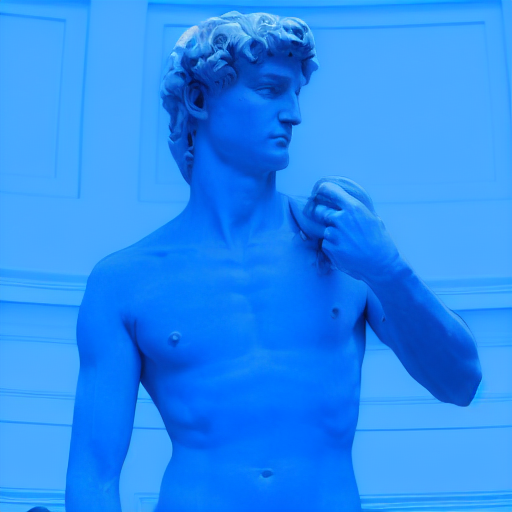

In [53]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
#https://huggingface.co/timbrooks/instruct-pix2pix
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)

prompt = "put a blue outfit on this person"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

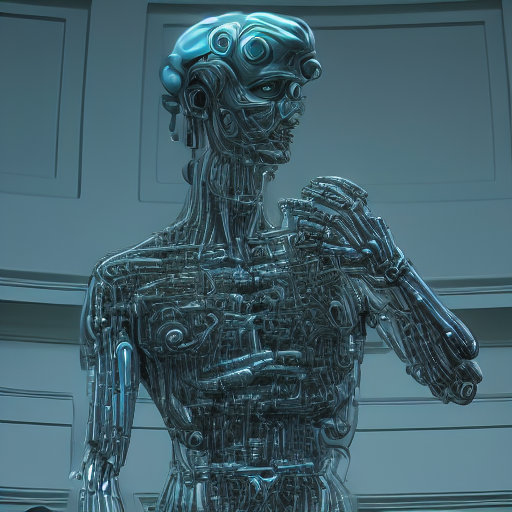

In [55]:
url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)

prompt = "transform it into a cybernetic organism"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

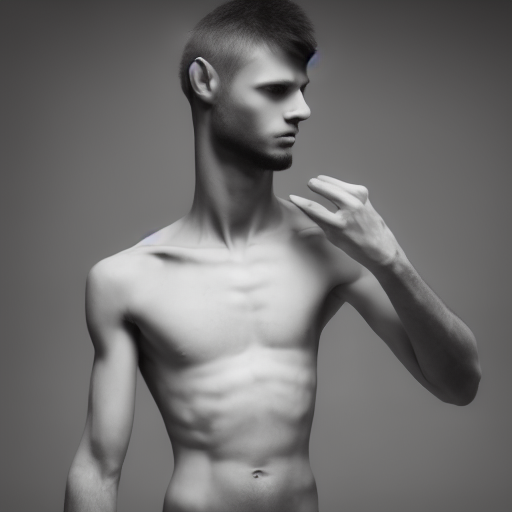

In [58]:
url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)

prompt = "turn him into a human being"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

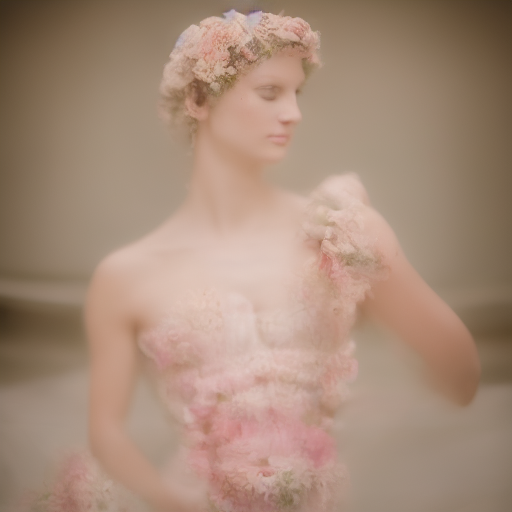

In [60]:
url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)

prompt = "make it beautiful"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

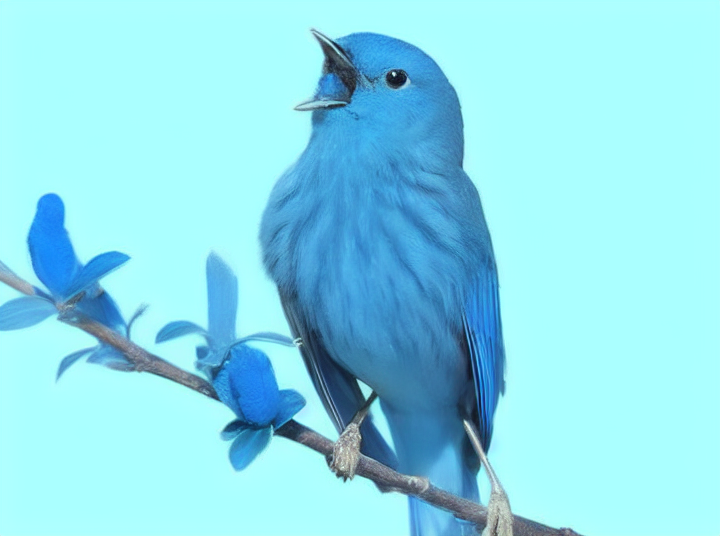

In [61]:
url = "https://www.birds.cornell.edu/home/wp-content/uploads/2018/10/BirdAcademy-720x540.jpg"
def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)

prompt = "make this bird blue"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

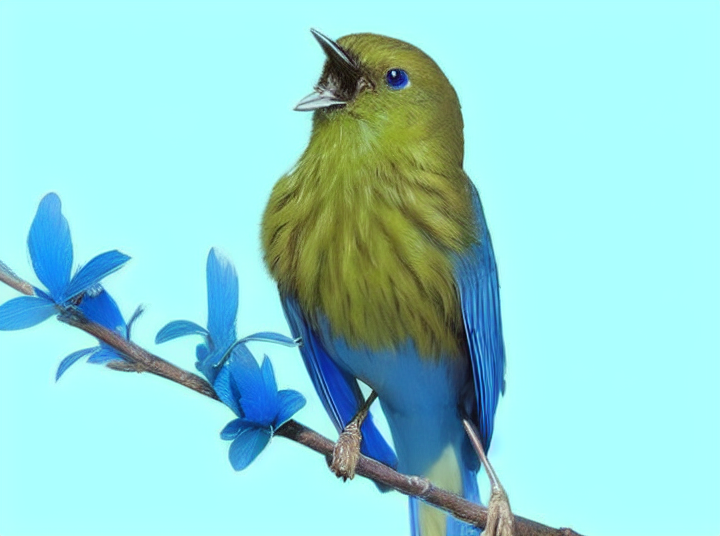

In [62]:
url = "https://www.birds.cornell.edu/home/wp-content/uploads/2018/10/BirdAcademy-720x540.jpg"
def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)

prompt = "make this bird's wings blue"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]